# Checking DHW using s2p3 downscaled Jen's NCEP run

In [14]:
import iris
import iris.coord_categorisation
import matplotlib.pyplot as plt
import numpy as np
import iris.quickplot as qplt
import netCDF4
import datetime
import scipy
import scipy.signal
import glob
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy.stats import t
import pickle
import os
import glob





In [15]:
def extract_region(cube,lon_west,lon_east,lat_south,lat_north):
    cube_region_tmp = cube.intersection(longitude=(lon_west, lon_east))
    cube_region = cube_region_tmp.intersection(latitude=(lat_south, lat_north))
    return cube_region

In [16]:
def area_avg(cube):
    try:
        cube.coord('latitude').guess_bounds()
        cube.coord('longitude').guess_bounds()
    except:
        pass
    grid_areas = iris.analysis.cartography.area_weights(cube)
    return cube.collapsed(['longitude','latitude'],iris.analysis.MEAN, weights=grid_areas)


def area_avg_not_weighted(cube):
    return cube.collapsed(['longitude','latitude'],iris.analysis.MEAN)



def area_max(cube):
    return cube.collapsed(['longitude','latitude'],iris.analysis.MAX)

In [17]:

def linregress_3D(y_array):
    # y_array is a 3-D array formatted like (time,lon,lat)
    # The purpose of this function is to do linear regression using time series of data over each (lon,lat) grid box with consideration of ignoring np.nan
    # Construct x_array indicating time indexes of y_array, namely the independent variable.
    x_array=np.empty(y_array.shape)
    for i in range(y_array.shape[0]): x_array[i,:,:]=i+1 # This would be fine if time series is not too long. Or we can use i+yr (e.g. 2019).
    x_array[np.isnan(y_array)]=np.nan
    # Compute the number of non-nan over each (lon,lat) grid box.
    n=np.sum(~np.isnan(x_array),axis=0)
    # Compute mean and standard deviation of time series of x_array and y_array over each (lon,lat) grid box.
    x_mean=np.nanmean(x_array,axis=0)
    y_mean=np.nanmean(y_array,axis=0)
    x_std=np.nanstd(x_array,axis=0)
    y_std=np.nanstd(y_array,axis=0)
    # Compute co-variance between time series of x_array and y_array over each (lon,lat) grid box.
    cov=np.nansum((x_array-x_mean)*(y_array-y_mean),axis=0)/n
    # Compute correlation coefficients between time series of x_array and y_array over each (lon,lat) grid box.
    cor=cov/(x_std*y_std)
    # Compute slope between time series of x_array and y_array over each (lon,lat) grid box.
    slope=cov/(x_std**2)
    # Compute intercept between time series of x_array and y_array over each (lon,lat) grid box.
    intercept=y_mean-x_mean*slope
    # Compute tstats, stderr, and p_val between time series of x_array and y_array over each (lon,lat) grid box.
    tstats=cor*np.sqrt(n-2)/np.sqrt(1-cor**2)
    stderr=slope/tstats
    p_val=t.sf(tstats,n-2)*2
    # Compute r_square and rmse between time series of x_array and y_array over each (lon,lat) grid box.
    # r_square also equals to cor**2 in 1-variable lineare regression analysis, which can be used for checking.
    r_square=np.nansum((slope*x_array+intercept-y_mean)**2,axis=0)/np.nansum((y_array-y_mean)**2,axis=0)
    rmse=np.sqrt(np.nansum((y_array-slope*x_array-intercept)**2,axis=0)/n)
    # Do further filteration if needed (e.g. We stipulate at least 3 data records are needed to do regression analysis) and return values
    n=n*1.0 # convert n from integer to float to enable later use of np.nan
    n[n<3]=np.nan
    slope[np.isnan(n)]=np.nan
    intercept[np.isnan(n)]=np.nan
    p_val[np.isnan(n)]=np.nan
    r_square[np.isnan(n)]=np.nan
    rmse[np.isnan(n)]=np.nan
#     return n,slope,intercept,p_val,r_square,rmse
    return slope,intercept

## Defining DHW and its MMM climatologies

### DHW MMM (Skirving definition):

* The MMM is calculated from 1985-2012 inclusive
* The data from the above period is averaged from daily to monthly
* Each calendar month from the 1985-2012 period (i.e. initially all Jans) are taken. Each grid point has a linear trend fitted to it through time, then the value coresponding to 1988.2857 on that linar trend is assigned to that grid point for that month. This is done for each claendar month. Now you have 12 2d fields, one for each month.
* Take the maximum of the 12 values for each pixel. This is the DHW MMM.

### DHW (Skirving definition):

* Working with daily data 
* Using the DHW MMM defined above, subtract the MMM from each daily timestep over your analysis period
* After the subtraction described above, **set all values less than 1 to 0**.
* for each point in space and time, look back over an 84 day window (no. days in **3 months**: 7 days * 4 weeks * 3 months), and sum up the values and asign the sum to the current day. i.e. sum up over anomalies a 3 month rolling window.
* **Divide by 7 to do from DHdays to DHweeks**


In [18]:
#DHM - 1985-2000

# https://rmets.onlinelibrary.wiley.com/doi/pdf/10.1002/joc.3486
# the monthly data set for 1982 – 2006 was first detrended using a linear regression, calculated for each month of the year and grid cell. The data set was detrended and centred on 1988
# I don't like this - it becoes ver deending on whether 1988 is a warm or cold year/...

def mmm_for_dhm(cube):
    years_for_mmm_climatology = [1985,2000]
    #####################################################
    #Avreage months separately!!!!!!!!!!!
#####################################################
    cube_years = cube.coord('year').points
    #subset the data into the bit you want to use to calculate the MMM climatology and the bit you want to calculate DHW on
    clim_cube = cube[np.where((cube_years >= years_for_mmm_climatology[0]) & (cube_years <= years_for_mmm_climatology[1]))]
    #collapse the months together, taking the maximum value at each lat-lon grid square
    mmm_climatology = clim_cube.collapsed('time',iris.analysis.MAX)
    return mmm_climatology



def mmm_skirving(cube):
    cube = cube.aggregated_by(['year','month'], iris.analysis.MEAN)
    print 'calculating NOAA Skirving MMM for month:'
#     missing_data_value_greater_than = -32768.0
#     missing_data_equals = -32768.0
#     missing_data_equals = cube.data.fill_value
    missing_data_equals = 9.96920997e+36
    print 'NOTE THIS SHOULD IDEALLY BE USING AN AVERAGE OF NIGHTIME TEMPERATURES, WHICH IS NOT A BED ESTIMATE FOR DAILY MEAN. A GOOD ALTERNATIEV FOR DAILY MEAN IS 10am (whet chris merchant does)'
    years_for_mmm_climatology = [1985,2012]
    standardisation_date = 1988.2857
    mm_cube = cube[0:12].copy()
    mm_cube_data = mm_cube.data.copy()
    cube_years = cube.coord('year').points
    #subset the data into the bit you want to use to calculate the MMM climatology and the bit you want to calculate DHW on
    clim_cube = cube[np.where((cube_years >= years_for_mmm_climatology[0]) & (cube_years <= years_for_mmm_climatology[1]))]
    clim_cube_detrended = clim_cube.copy()
    clim_cube_detrended_data = clim_cube_detrended.data
    print np.shape(clim_cube_detrended)
    for i,month in enumerate(np.unique(cube.coord('month_number').points)):
        print i+1
        loc = np.where(clim_cube.coord('month_number').points == month)
        tmp = clim_cube_detrended_data[loc,:,:][0]
        tmp[np.where(tmp == missing_data_equals )] = np.nan
        slope,intercept = linregress_3D(tmp)
        x = standardisation_date - years_for_mmm_climatology[0]
        y = (slope * x ) + intercept
        mm_cube_data[i,:,:] = y
    mm_cube.data = mm_cube_data
    mmm_climatology = mm_cube.collapsed('time',iris.analysis.MAX)
    return mmm_climatology

In [19]:
def dhm(cube,mmm_climatology,years_over_which_to_calculate_dhm):
    missing_data_value = cube.data.fill_value
    #This hsould be given monthly data
    # One DHM == 4DHW This is important
#     mmm is straight averg not fdetreneded for DHM
    #Look at the donna poapers - look over two papers...
    #accumulation window is 4 months rather than 3 months.
    cube_years = cube.coord('year').points
#     print cube_years
#     print years_over_which_to_calculate_dhm[0]
#     print years_over_which_to_calculate_dhm[1]
    main_cube = cube[np.where((cube_years >= years_over_which_to_calculate_dhm[0]) & (cube_years <= years_over_which_to_calculate_dhm[1]))]
    main_cube_data = main_cube.data.copy()
    main_cube_data[np.where(main_cube_data == missing_data_value )] = np.nan
    main_cube.data = main_cube_data
    
    #subtract the monthly mean climatology from the rest of the data
    main_cube -= mmm_climatology # at this stage this is called a hot spot (which is anything greater than the mmm)

    #set all values less than 1 to zero
#     main_cube.data[np.where(main_cube.data <= 1.0)] = 0.0
    #OR
    main_cube_data = main_cube.data.copy()
    main_cube_data[np.where(main_cube_data < 0.0)] = 0.0
#     main_cube_data[np.where(main_cube_data == missing_data_value )] = np.nan
    main_cube.data = main_cube_data
    
    #make a cube to hold the output data
    output_cube = main_cube[3::].copy()
    output_cube.data[:] = np.nan
    output_cube_data = output_cube.data.copy()

        #AVEREG OVER A 4 month  window rather than 3 month when it comes to DHW


    #loop through from day 112 to the end of the dataset
    for i in range(output_cube.shape[0]):
#         print i,' of ',output_cube.shape[0]
        tmp_data = main_cube[i:i+4].collapsed('time',iris.analysis.SUM)
        output_cube_data[i,:,:] = tmp_data.data

    #save the output
    output_cube.data = output_cube_data
    return output_cube

In [20]:
def dhw(cube,mmm_climatology,years_over_which_to_calculate_dhw):
    cube_years = cube.coord('year').points
    #note this is to be uef with daily data...
    main_cube = cube[np.where((cube_years > years_over_which_to_calculate_dhw[0]) & (cube_years < years_over_which_to_calculate_dhw[1]))]
    #subtract the monthly mean climatology from the rest of the data
    main_cube -= mmm_climatology
    #set all values less than 1 to zero
    main_cube.data[np.where(main_cube.data < 1.0)] = 0.0 

    #make a cube to hold the output data
    output_cube = main_cube[83::].copy()
    output_cube.data[:] = np.nan
    output_cube_data = output_cube.data.copy()

    #loop through from day 84 to the end of the dataset
    for i in range(output_cube.shape[0]):
#         print i,' of ',output_cube.shape[0]
        #sum the temperatures in that 84 day window and divide result by 7 to get in DHWeeks rather than DHdays
        tmp_data = main_cube[i:i+84].collapsed('time',iris.analysis.SUM)/7.0
        output_cube_data[i,:,:] = tmp_data.data

    #save the output
    output_cube.data = output_cube_data
    return output_cube

# Read in s2p3 data

In [21]:
directory = '/Users/ph290/Downloads/'

files = glob.glob(directory+'ST_NCEP_1982_2018.nc')
#NOTE copy this across as soon as it is processed
cube = iris.load_cube(files)

try:
    iris.coord_categorisation.add_year(cube, 'time', name='year')
    iris.coord_categorisation.add_month(cube, 'time', name='month')
    iris.coord_categorisation.add_month_number(cube, 'time', name='month_number')
    iris.coord_categorisation.add_day_of_month(cube, 'time', name='day_of_month')
except:
    pass

# Calculate DHW

In [22]:
lon_west = 142.0
lon_east = 157.0
lat_south = -30.0
lat_north = -10.0

years_over_which_to_calculate_dhw = [2012,2018]
# cube_region = extract_region(cube,lon_west,lon_east,lat_south,lat_north)
cube_region = extract_region(cube,lon_west,lon_east,lat_south,lat_north)



In [23]:
mmm_climatology_dhw = mmm_skirving(cube_region)
dhw_cube_gbr = dhw(cube_region,mmm_climatology_dhw,years_over_which_to_calculate_dhw)

calculating NOAA Skirving MMM for month:
NOTE THIS SHOULD IDEALLY BE USING AN AVERAGE OF NIGHTIME TEMPERATURES, WHICH IS NOT A BED ESTIMATE FOR DAILY MEAN. A GOOD ALTERNATIEV FOR DAILY MEAN IS 10am (whet chris merchant does)
(336, 376, 298)
1


/Users/ph290/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: Mean of empty slice
  if sys.path[0] == '':
/Users/ph290/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: Mean of empty slice
  del sys.path[0]
/Users/ph290/miniconda2/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:1427: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/Users/ph290/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in divide
/Users/ph290/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in sqrt
/Users/ph290/miniconda2/lib/python2.7/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/ph290/miniconda2/lib/python2.7/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encounte

2
3
4
5
6
7
8
9
10
11
12


/Users/ph290/miniconda2/lib/python2.7/site-packages/iris/coords.py:1017: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for u'day_of_month'.
  warnings.warn(msg.format(self.name()))
/Users/ph290/miniconda2/lib/python2.7/site-packages/iris/coords.py:1017: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for u'month_number'.
  warnings.warn(msg.format(self.name()))
/Users/ph290/miniconda2/lib/python2.7/site-packages/iris/coords.py:1017: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for u'time'.
  warnings.warn(msg.format(self.name()))
/Users/ph290/miniconda2/lib/python2.7/site-packages/iris/coords.py:1017: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for u'year'.
  warnings.warn(msg.format(self.name()))
/Users/ph290/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encou

### masking land points

In [50]:
dhw_cube_gbr.data = np.ma.masked_array(dhw_cube_gbr.data)
dhw_cube_gbr_data = dhw_cube_gbr.data
# dhw_cube_gbr_data[np.where(dhw_cube_gbr_data == 9.96920997e+36)] = 0.0
dhw_cube_gbr_data[np.where(np.logical_not(np.isfinite(dhw_cube_gbr_data)))] = 0.0
dhw_cube_gbr.data = dhw_cube_gbr_data
dhw_cube_gbr.data.mask = np.broadcast_to(cube_region[0].data == 9.96920997e+36, dhw_cube_gbr.data.shape)


In [65]:
def asb(cube,threshold):
    dhvalue_cube_gbr_tmp = cube.copy()
    dhvalue_cube_gbr_tmp_data = dhvalue_cube_gbr_tmp.data
    dhvalue_cube_gbr_tmp_data[np.where(dhvalue_cube_gbr_tmp_data <= threshold)] = 0.0
    dhvalue_cube_gbr_tmp_data[np.where(dhvalue_cube_gbr_tmp_data > threshold)] = 1.0
    dhvalue_cube_gbr_tmp.data = dhvalue_cube_gbr_tmp_data
    dhvalue_cube_gbr_asb = dhvalue_cube_gbr_tmp.copy()
    dhvalue_cube_gbr_asb = dhvalue_cube_gbr_tmp.aggregated_by(['year'], iris.analysis.SUM)
    dhvalue_cube_gbr_asb_tmp = dhvalue_cube_gbr_asb.data
    dhvalue_cube_gbr_asb_tmp[np.where(dhvalue_cube_gbr_asb_tmp > 1.0)] = 1.0
    dhvalue_cube_gbr_asb.data = dhvalue_cube_gbr_asb_tmp
    return dhvalue_cube_gbr_asb


# dhw_cube_gbr.data = np.ma.masked_where(dhw_cube_gbr.data == dhw_cube_gbr.data.fill_value,dhw_cube_gbr.data)


# dhm_cube_gbr = extract_region(dhm_cube_gbr,lon_west,lon_east,lat_south,lat_north)
dhw_cube_gbr_asb = asb(dhw_cube_gbr.copy(),8.0)
dhw_cube_gbr_asb_area_avg = area_avg(dhw_cube_gbr_asb.aggregated_by(['year'], iris.analysis.MAX))
# dhw_cube_gbr.data[np.where(dhw_cube_gbr.data == 0.0)] = np.nan
dhw_avg = area_avg(dhw_cube_gbr.aggregated_by(['year'], iris.analysis.MEAN))



## The following looks at DHW 

### Maximum **DHW** in each grid box over 2012-2018

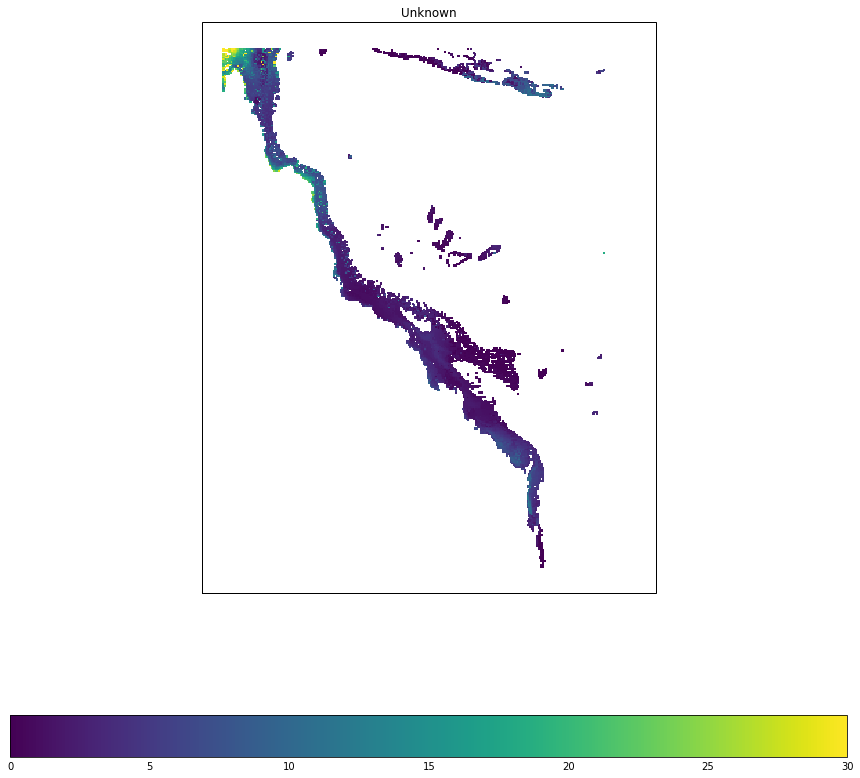

In [57]:
fig = plt.figure(figsize=(15, 15))
dhw_cube_gbr_max = dhw_cube_gbr.collapsed('time',iris.analysis.MAX)
qplt.pcolormesh(dhw_cube_gbr_max,vmin=0,vmax=30)


### Time mean **DHW** in each grid box over 2012-2018

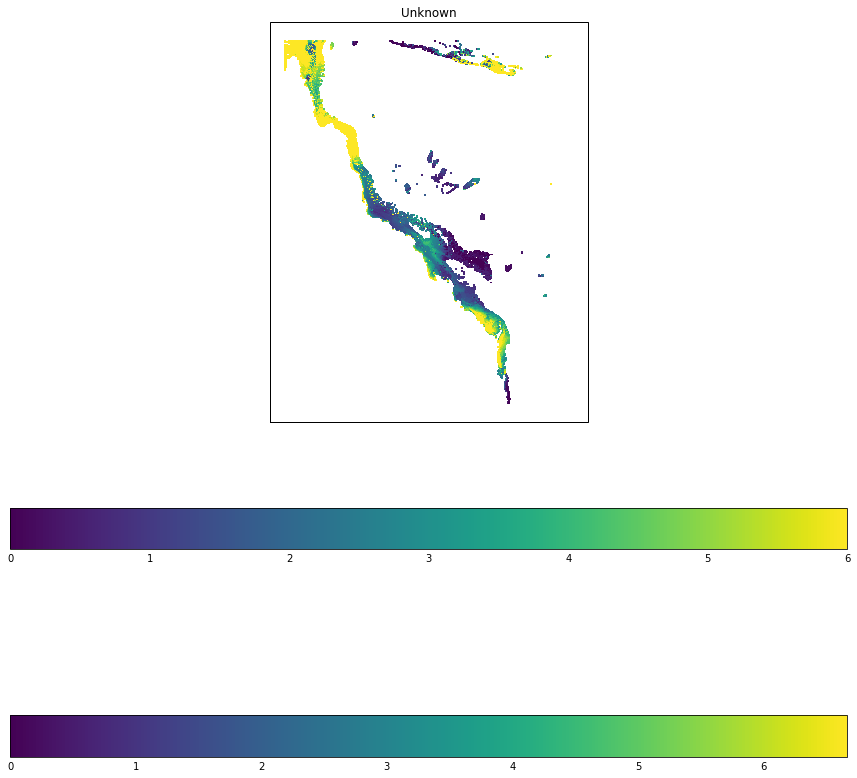

In [58]:
fig = plt.figure(figsize=(15, 15))
dhw_cube_gbr_mean = dhw_cube_gbr.collapsed('time',iris.analysis.MEAN)
qplt.pcolormesh(dhw_cube_gbr_mean)
qplt.pcolormesh(dhw_cube_gbr_max,vmin=0,vmax=6)



In [59]:
dhw_avg = area_avg(dhw_cube_gbr.aggregated_by(['year'], iris.analysis.MEAN))

dhw_max = area_max(dhw_cube_gbr.aggregated_by(['year'], iris.analysis.MAX))


### Average DHW in time and space in each grid box over 2012-2018, using region in above plots

Text(0.5,0,'year')

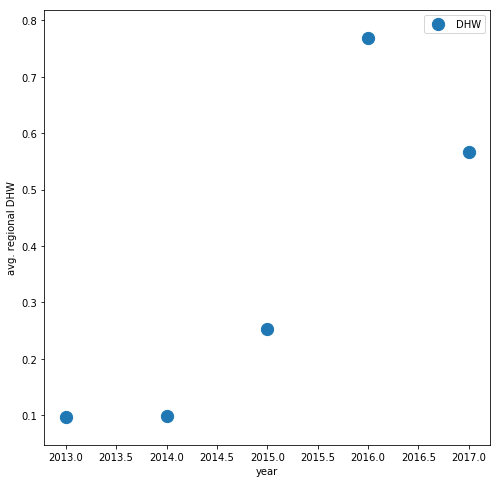

In [60]:
fig = plt.figure(figsize=(8, 8))
plt.scatter(dhw_avg.coord('year').points,dhw_avg.data,s=150,label='DHW')
plt.ylabel('avg. regional DHW')
plt.legend()
plt.xlabel('year')

### Maximum DHW in time and space in each grid box over 2012-2018, using region in above plots

Text(0.5,0,'year')

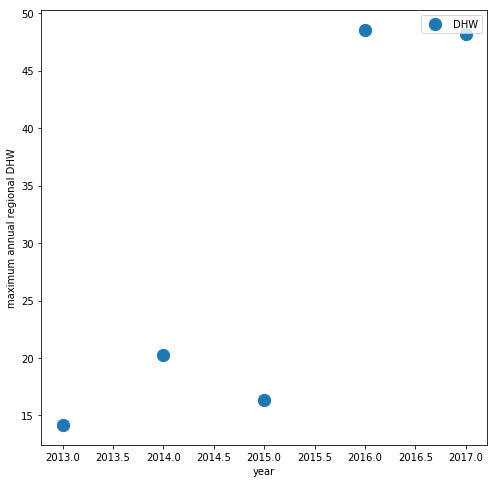

In [64]:
fig = plt.figure(figsize=(8, 8))
plt.scatter(dhw_avg.coord('year').points,dhw_max.data,s=150,label='DHW')
plt.ylabel('maximum annual regional DHW')
plt.legend()
plt.xlabel('year')